In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import K2fov
import numpy as np
%matplotlib inline
from tqdm import tqdm
import astropy.units as u
from datetime import datetime
from astropy.coordinates import SkyCoord
plt.style.use('ggplot')

In [2]:
k2 = pd.read_csv('/Users/ch/K2/repos/exoplanet-charts/data/k2-candidate-planets.csv', comment='#')
confirmed = k2.k2c_disp == 'CONFIRMED'

In [3]:
k2 = k2.drop_duplicates('epic_name')

In [4]:
def planetspercampaign(df):
    campaigns = np.arange(0, 18)
    nplanets = np.zeros(len(campaigns))
    for campaign in campaigns:
        ok = np.zeros(len(df), dtype=bool)
        for idx, k in enumerate(df.k2_campaign_str):
            try:
                ok[idx] = np.min(np.asarray(k.split(','), dtype=int)) == campaign
            except:
                continue
        if campaign==16:
            print(np.where(ok == True))
        nplanets[campaign-1] = len(df[ok])
    return campaigns, nplanets

(array([], dtype=int64),)
(array([], dtype=int64),)


/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<Container object of 18 artists>

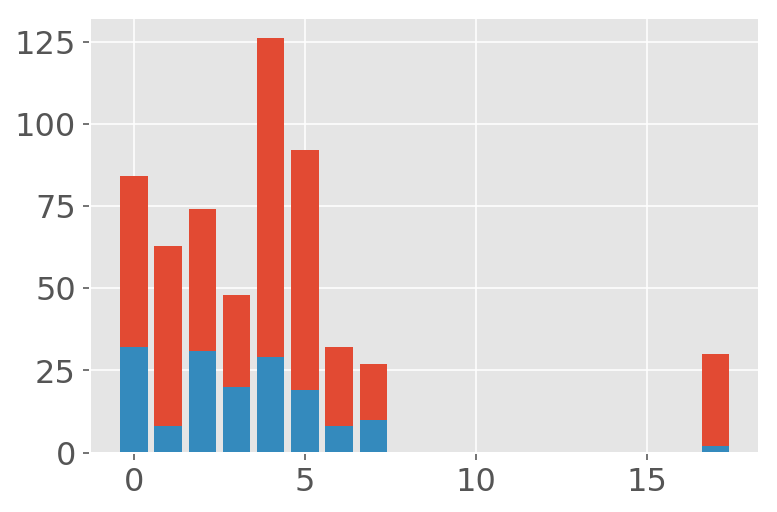

In [5]:
campaigns, nplanets = planetspercampaign(k2)
plt.bar(campaigns, nplanets)
campaigns, nplanets = planetspercampaign(k2[confirmed])
plt.bar(campaigns, nplanets)

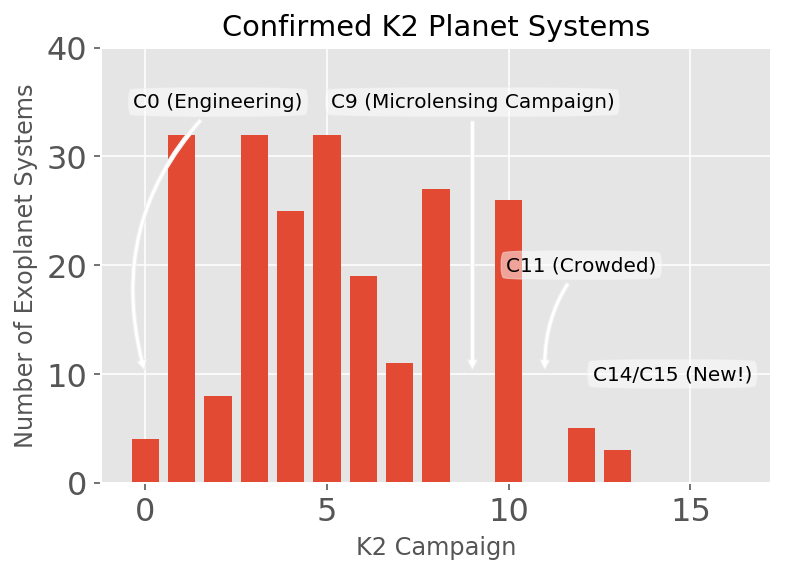

In [6]:
fig, ax = plt.subplots()
mast = pd.read_csv('k2confirmedmast.csv', skiprows = [1])
mast = mast.drop_duplicates('K2 ID')
mast.loc[0:1, 'K2 Campaign'] = '0'


h = plt.hist(np.asarray(mast['K2 Campaign'], dtype=float), np.arange(0, 18, 1)-0.5, rwidth=0.75)
plt.xlabel('K2 Campaign')
plt.ylabel('Number of Exoplanet Systems');
plt.title('Confirmed K2 Planet Systems')
plt.ylim(0,40 )

plt.savefig('planetdiscoveries_1.png', dpi=300, bbox_inches='tight')
ann = ax.annotate("C0 (Engineering)",
                  xy=(0, 10), xycoords='data',
                  xytext=(2, 35), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w", alpha=0.5),
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=0.3",
                                  fc="w"), 
                  )
plt.savefig('planetdiscoveries_2.png', dpi=300, bbox_inches='tight')

ann = ax.annotate("C9 (Microlensing Campaign)",
                  xy=(9, 10), xycoords='data',
                  xytext=(9, 35), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w", alpha=0.5),
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=0",
                                  fc="w"), 
                  )
plt.savefig('planetdiscoveries_3.png', dpi=300, bbox_inches='tight')


ann = ax.annotate("C11 (Crowded)",
                  xy=(11, 10), xycoords='data',
                  xytext=(12, 20), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w", alpha=0.5),
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=0.2",
                                  fc="w"), 
                  )
plt.savefig('planetdiscoveries_4.png', dpi=300, bbox_inches='tight')


ann = ax.annotate("C14/C15 (New!)",
                  xy=(14.5, 10), xycoords='data',
                  xytext=(14.5, 10), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w", alpha=0.5),
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=0",
                                  fc="w"), 
                  )
plt.savefig('planetdiscoveries_5.png', dpi=300, bbox_inches='tight')



In [18]:
df = pd.read_csv('planets.csv', comment='#')
df = df[df.pl_tranflag==1].reset_index(drop=True)

k2 = df[(df.pl_k2flag==1)&(df.pl_facility=='K2')].reset_index(drop=True)
kepler = df[(df.pl_kepflag==1)&(df.pl_facility=='Kepler')].reset_index(drop=True)
notk = df[(df.pl_kepflag==0) & (df.pl_k2flag==0) & (df.pl_discmethod=='Transit')]



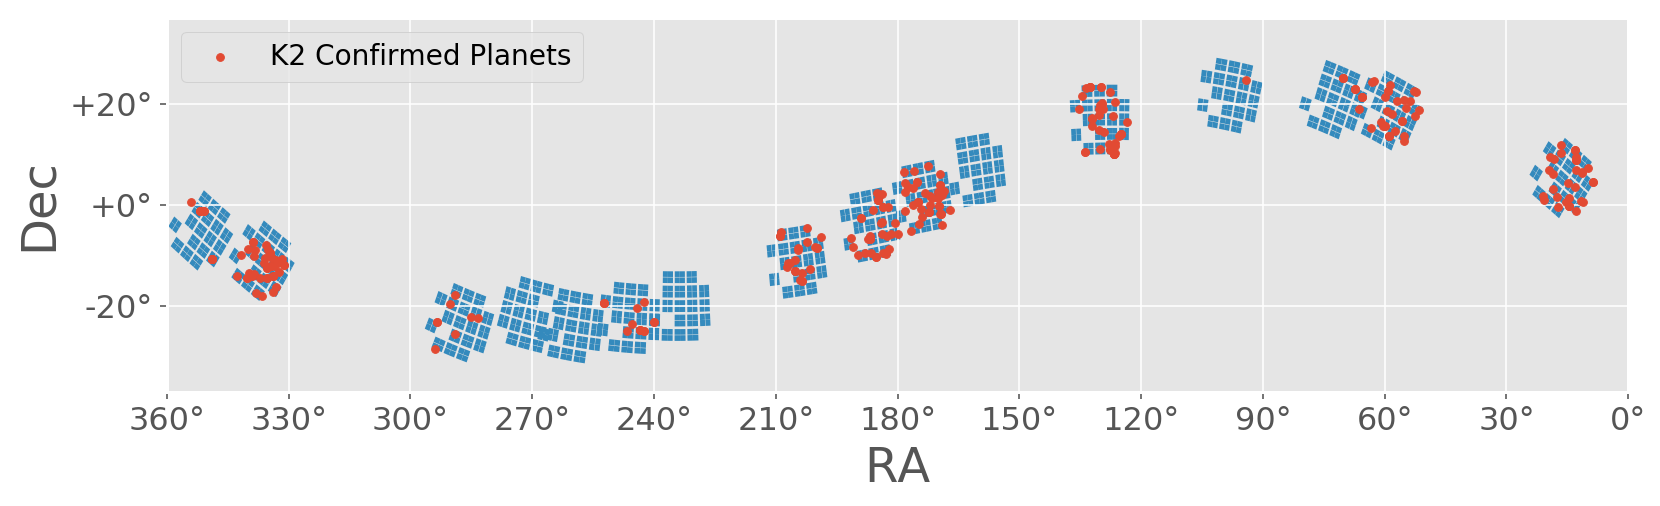

In [63]:
from K2fov import plot
CAMPAIGN = 0

p = plot.K2FootprintPlot(figsize=(12, 4))
for campaign in np.arange(0,16):
    p.plot_campaign(campaign, annotate_channels=False, facecolor='C1', lw=0, zorder=-1)
    
plt.scatter(k2.ra, k2.dec, c='C0', zorder=10, s=15, label='K2 Confirmed Planets')  
plt.legend()
plt.savefig('planets_radec.png', dpi=300, bbox_inches='tight')

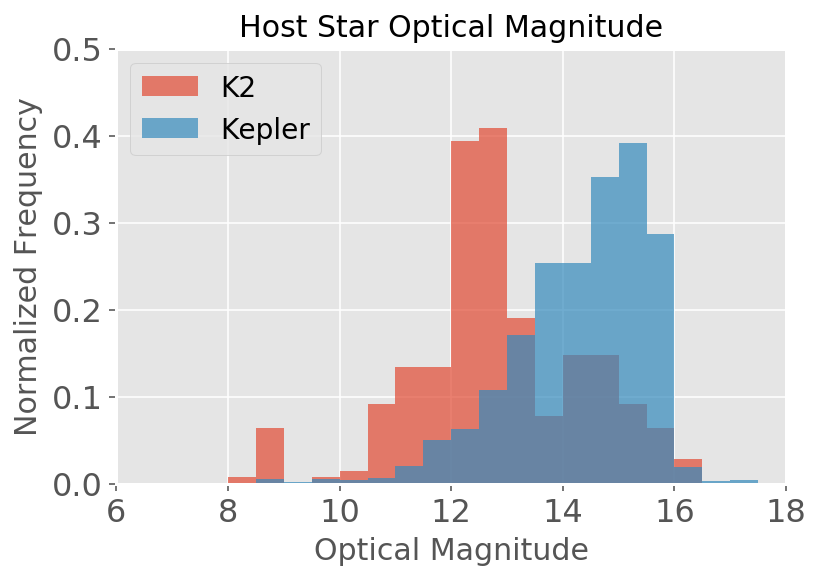

In [60]:
fig, ax = plt.subplots()
mag = k2.st_optmag
h = ax.hist(mag[np.isfinite(mag)], np.arange(5,20,0.5), normed=True, label='K2', alpha=0.7);
mag = kepler.st_optmag
_ = ax.hist(mag[np.isfinite(mag)], h[1], normed=True, label='Kepler', alpha=0.7);
ax.legend()
ax.set_ylabel('Normalized Frequency', fontsize=15)
ax.set_xlabel('Optical Magnitude', fontsize=15)
ax.set_title('Host Star Optical Magnitude', fontsize=15)
plt.ylim(0, 0.5)
plt.xlim(6, 18)
plt.savefig('optical.png', dpi=300, bbox_inches='tight')



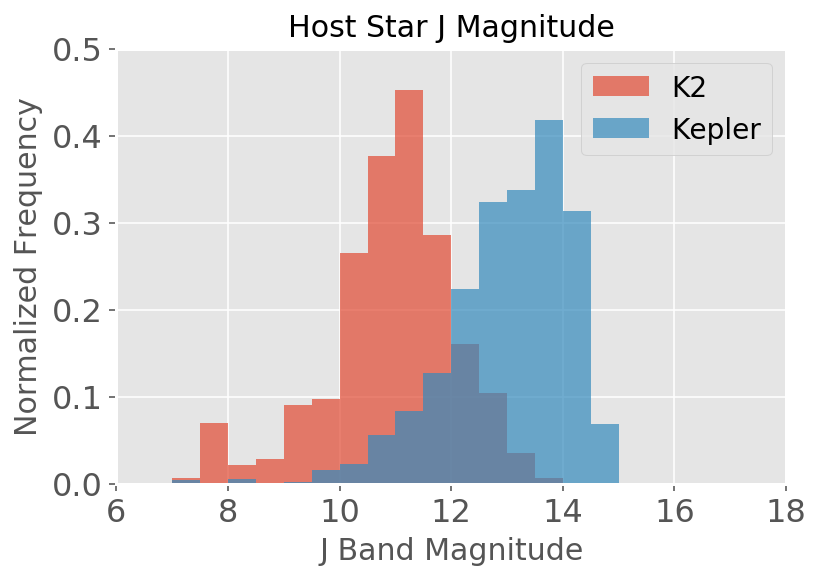

In [61]:
fig, ax = plt.subplots()
mag = k2.st_j
h = ax.hist(mag[np.isfinite(mag)], np.arange(5,20,0.5), normed=True, label='K2', alpha=0.7);
mag = kepler.st_j
_ = ax.hist(mag[np.isfinite(mag)], h[1], normed=True, label='Kepler', alpha=0.7);
ax.legend()
ax.set_ylabel('Normalized Frequency', fontsize=15)
ax.set_xlabel('J Band Magnitude', fontsize=15)
ax.set_title('Host Star J Magnitude', fontsize=15)
plt.ylim(0, 0.5)
plt.xlim(6, 18)
plt.savefig('jband.png', dpi=300, bbox_inches='tight')



In [22]:
def planetsperyear(res = kepler):
    yrs, count = [], []
    for i in np.sort(np.unique(res.pl_disc)):
        yrs.append(i)
        count.append(len(res[res.pl_disc == i]))
    yrs = np.asarray(yrs)
    count = np.asarray(count)
    return yrs, count

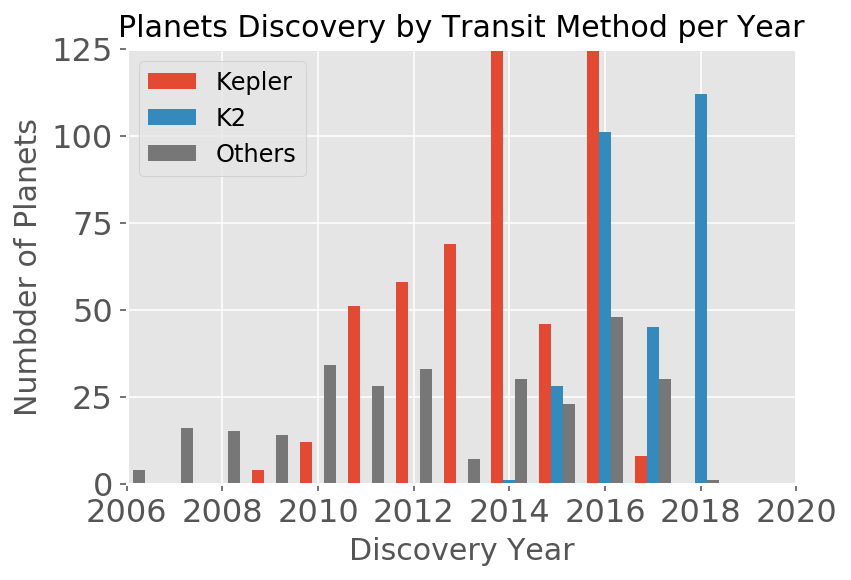

In [64]:
yrs, count = planetsperyear(kepler)
plt.bar(yrs-0.25, count, 0.25, label='Kepler')
yrs, count = planetsperyear(k2)
plt.bar(yrs, count, 0.25,  label='K2')
yrs, count = planetsperyear(notk)
plt.bar(yrs+0.25, count, 0.25, label='Others', color='C3')


plt.legend(fontsize=12)
plt.ylim(0,125)
plt.xlim(2006, 2019)
_ = plt.xticks(np.arange(2006,2022,2));
plt.xlabel('Discovery Year', fontsize=15)
plt.ylabel('Numbder of Planets', fontsize=15)
plt.title('Planets Discovery by Transit Method per Year', fontsize=15)

plt.savefig('planetdiscoverys.png', dpi=300, bbox_inches='tight')